# ETF Portfolio Optimisation
This module:
- processes the Yahoo Finance data on historical performance of a set of hand-picked ETFs,
- unifies the data by converting it to Polish Zloty,
- assess the expected return and volatility of my current portfolio,
- optimises a portfolio of ETFs using the PyPortfolioOpt (`pypfopt`) package.

In [19]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [20]:
START_DATE = date(2000, 1, 1)
END_DATE = date(2023, 1, 31)

In [21]:
def read_yahoo_csv(filepath):
    df = pd.read_csv(filepath)[["Date", "Adj Close"]]
    df["Date"] = pd.to_datetime(df["Date"])

    column_name = ".".join(os.path.basename(filepath).split(".")[:-1])

    df.rename(columns={"Adj Close": column_name}, inplace=True)
    return df


def read_yahoo_folder(folderpath, start, end):
    df = pd.DataFrame({"Date": pd.date_range(start, end, freq="D")})

    with os.scandir(folderpath) as entries:
        for entry in entries:
            df = df.merge(read_yahoo_csv(entry), on="Date", how="left")

    df.set_index("Date", inplace=True)
    return df

Data was downloaded manually from the Yahoo Finance website. There is data for both the ETF ratings in their issue currency as well as for the exchange rates. The exchange rate that everything will be recalculated into is Polish Zloty (PLN).

In [22]:
etf_df = read_yahoo_folder("data/etfs/", START_DATE, END_DATE)
exchange_rates_df = read_yahoo_folder("data/exchange-rates/", START_DATE, END_DATE)

[Text(0.5, 1.0, 'Exchange rates to PLN'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Price of currency in PLN')]

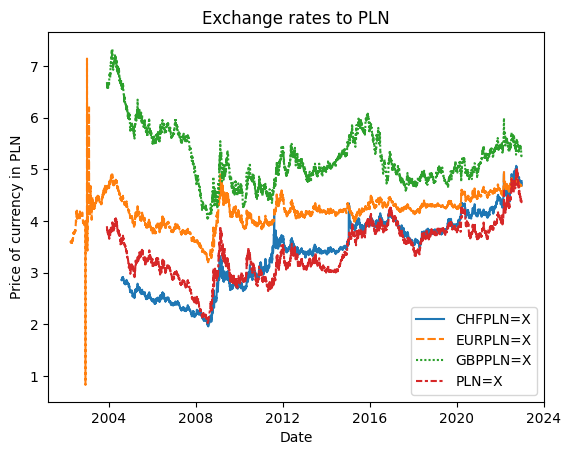

In [23]:
plot = sns.lineplot(data=exchange_rates_df)
plot.set(
    title="Exchange rates to PLN", xlabel="Date", ylabel="Price of currency in PLN"
)

There is something weird going on with the EUR to PLN plot around 2002-2003, but let's ignore this for now. This period will fall out of the analysis anyways.

Keep in mind that the weirdly labeled `PLN=X` item stands for the USD to PLN exchange rate. The name comes from the label on the Yahoo Finance website.

This is not very useful just yet. Let's bring all values to PLN first. Note that Yahoo Finance presents some ETF's values in fractions. These need to be included as well.

In [24]:
etf_currencies = {
    "SGLN.L": ["GBPPLN=X", 0.01],
    "STNX.SW": ["CHFPLN=X", 1],
    "SWDA.L": ["GBPPLN=X", 0.01],
    "PHPM.L": ["PLN=X", 1],
    "SPYD.DE": ["EURPLN=X", 1],
    "AEEM.PA": ["EURPLN=X", 1],
    "XDWH.L": ["PLN=X", 1],
}

for column_name in etf_df.columns:
    etf_df[column_name] = (
        etf_df[column_name]
        * exchange_rates_df[etf_currencies[column_name][0]]
        * etf_currencies[column_name][1]
    )

Now, let's remove rows where the data is not full, so that all series start from the same point in time.

In [25]:
etf_df.dropna(inplace=True)

 Also, let's standarise the output, to make it easier to see differences in value. Before we do that, though, let's write down the latest prices.

In [26]:
latest_prices = get_latest_prices(etf_df)
latest_prices

AEEM.PA     19.888197
PHPM.L     586.651109
SGLN.L     152.883882
SPYD.DE    302.034633
STNX.SW    854.922003
SWDA.L     319.144446
XDWH.L     213.132837
Name: 2022-12-23 00:00:00, dtype: float64

A function to normalize asset prices to start at the same value:

In [27]:
def normalize(df, start_value=100):
    return df.div(df.iloc[0] / start_value)

In [31]:
etf_df = normalize(etf_df)
etf_df

,AEEM.PA,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L,XDWH.L
Date,,,,,,,
2011-10-14,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2011-10-17,101.492397,99.424854,100.311243,99.948786,100.326435,99.247750,97.428794
2011-10-18,101.746175,99.193810,100.218232,101.354843,102.080533,100.849047,100.172831
2011-10-19,101.491453,99.778431,99.487012,100.938815,103.302874,101.127185,100.044201
2011-10-20,99.486979,96.689167,97.927457,100.452838,101.673715,100.003301,99.699632
...,...,...,...,...,...,...,...
2022-12-19,181.435277,144.741134,148.138956,380.341403,264.130341,386.204800,525.286624
2022-12-20,180.767466,147.663010,150.205653,377.569842,263.535363,384.796731,522.567402
2022-12-21,181.354428,146.104063,150.683401,383.493156,268.213853,392.060799,528.011087


[Text(0.5, 1.0, 'Portfolio components history in standardized prices'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Relative value in PLN')]

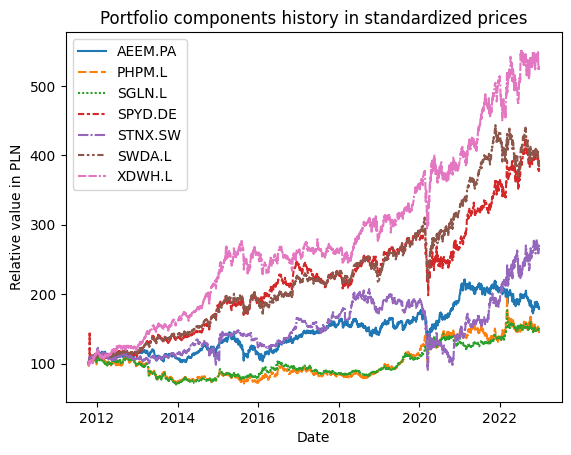

In [32]:
plot = sns.lineplot(data=etf_df)
plot.set(
    title="Portfolio components history in normalized prices",
    xlabel="Date",
    ylabel="Relative value in PLN",
)

## Evaluation of selected portfolio

Now it's time for the portfolio evaluation. We need to calculate expected yearly returns and the annualized covariance matrix.

In [82]:
mean_historical_returns = expected_returns.mean_historical_return(etf_df)
mean_historical_returns

AEEM.PA    0.055625
PHPM.L     0.034578
SGLN.L     0.036475
SPYD.DE    0.131425
STNX.SW    0.096081
SWDA.L     0.132983
XDWH.L     0.166904
dtype: float64

In [83]:
covariance_matrix = risk_models.sample_cov(etf_df)
covariance_matrix

,AEEM.PA,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L,XDWH.L
AEEM.PA,0.036131,0.010480,0.002134,0.021930,0.019958,0.020289,0.016826
PHPM.L,0.010480,0.048846,0.028107,0.008856,0.017545,0.010997,0.017446
SGLN.L,0.002134,0.028107,0.033689,0.001403,0.006274,0.010124,0.005845
SPYD.DE,0.021930,0.008856,0.001403,0.058459,0.022050,0.024385,0.021544
STNX.SW,0.019958,0.017545,0.006274,0.022050,0.071507,0.019126,0.017903
SWDA.L,0.020289,0.010997,0.010124,0.024385,0.019126,0.031257,0.022188
XDWH.L,0.016826,0.017446,0.005845,0.021544,0.017903,0.022188,0.033687


Let's assign weights to the ETFs based on my current allocation.

In [84]:
current_weights = np.array([0, 0, 0, 0.4, 0, 0.1, 0.5])

Now we calculate the variance and the volatility (standard deviation) of the specified portfolio.

In [85]:
def assess_portfolio(weights, expected_returns, covariance_matrix):
    expected_portfolio_return = np.sum(expected_returns * weights)
    expected_portfolio_volatility = np.sqrt(weights.T @ covariance_matrix @ weights)

    return [expected_portfolio_return, expected_portfolio_volatility]


print(
    "Expected annual return: {:.2%}".format(
        assess_portfolio(current_weights, mean_historical_returns, covariance_matrix)[0]
    )
)
print(
    "Expected annual volatility: {:.2%}".format(
        assess_portfolio(current_weights, mean_historical_returns, covariance_matrix)[1]
    )
)

Expected annual return: 14.93%
Expected annual volatility: 17.57%


## Portfolio optimisation

Optimize for max Sharpe ratio

In [86]:
ef = EfficientFrontier(mean_historical_returns, covariance_matrix)
optimal_weights = ef.max_sharpe()
cleaned_optimal_weights = ef.clean_weights()
print(cleaned_optimal_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('AEEM.PA', 0.0), ('PHPM.L', 0.0), ('SGLN.L', 0.0), ('SPYD.DE', 0.04151), ('STNX.SW', 0.0), ('SWDA.L', 0.18095), ('XDWH.L', 0.77754)])
Expected annual return: 15.9%
Annual volatility: 17.2%
Sharpe Ratio: 0.81


(0.1592932537886897, 0.17172824113493937, 0.8111260726139788)

Get the discrete allocation of each share per stock

In [87]:
da = DiscreteAllocation(
    cleaned_optimal_weights, latest_prices, total_portfolio_value=50000
)

allocation, leftover = da.lp_portfolio()
print("Discrete Allocation:", allocation)
print("Funds Remaining: {:.2f} zł".format(leftover))

Discrete Allocation: {'AEEM.PA': 1, 'SPYD.DE': 7, 'SWDA.L': 28, 'XDWH.L': 182}
Funds Remaining: 139.65 zł


Let's generate a random portfolio (i.e. a vector of non-negative numbers which sum up to one). For the details of how the function works, please see discussion in the [other notebook](random_portfolio_generator.ipynb).

In [88]:
def generate_random_weights(num_components):
    random_uniform = np.random.rand(num_components)
    random_exponential = np.log(random_uniform)
    return random_exponential / np.sum(random_exponential)

In [89]:
def generate_and_evaluate_random_portfolios(
    num_portfolios, expected_returns, covariance_matrix
):
    results = np.zeros((num_portfolios, 2))

    for i in range(num_portfolios):
        random_weights = generate_random_weights(covariance_matrix.shape[0])
        results[i, 0], results[i, 1] = assess_portfolio(
            random_weights, expected_returns, covariance_matrix
        )

    results = pd.DataFrame(results)
    results.columns = ["Annualised return", "Annualised volatility"]

    return results

In [92]:
portfolio_evaluations = generate_and_evaluate_random_portfolios(
    100_000, mean_historical_returns, covariance_matrix
)

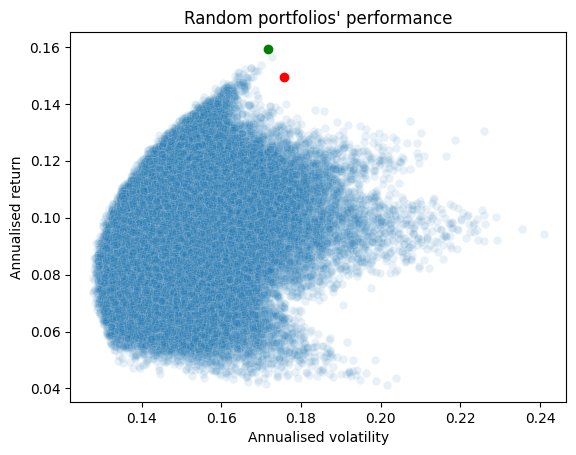

In [93]:
random_portfolios_plot = sns.scatterplot(
    data=pd.DataFrame(portfolio_evaluations),
    alpha=0.1,
    x="Annualised volatility",
    y="Annualised return",
)

random_portfolios_plot.set(title="Random portfolios' performance")

plt.scatter(
    x=assess_portfolio(current_weights, mean_historical_returns, covariance_matrix)[1],
    y=assess_portfolio(current_weights, mean_historical_returns, covariance_matrix)[0],
    color="r",
)

plt.scatter(x=ef.portfolio_performance()[1], y=ef.portfolio_performance()[0], color="g")